In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import os

Iniciando análisis exploratorio...
Estadísticas descriptivas:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

Valores nulos:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


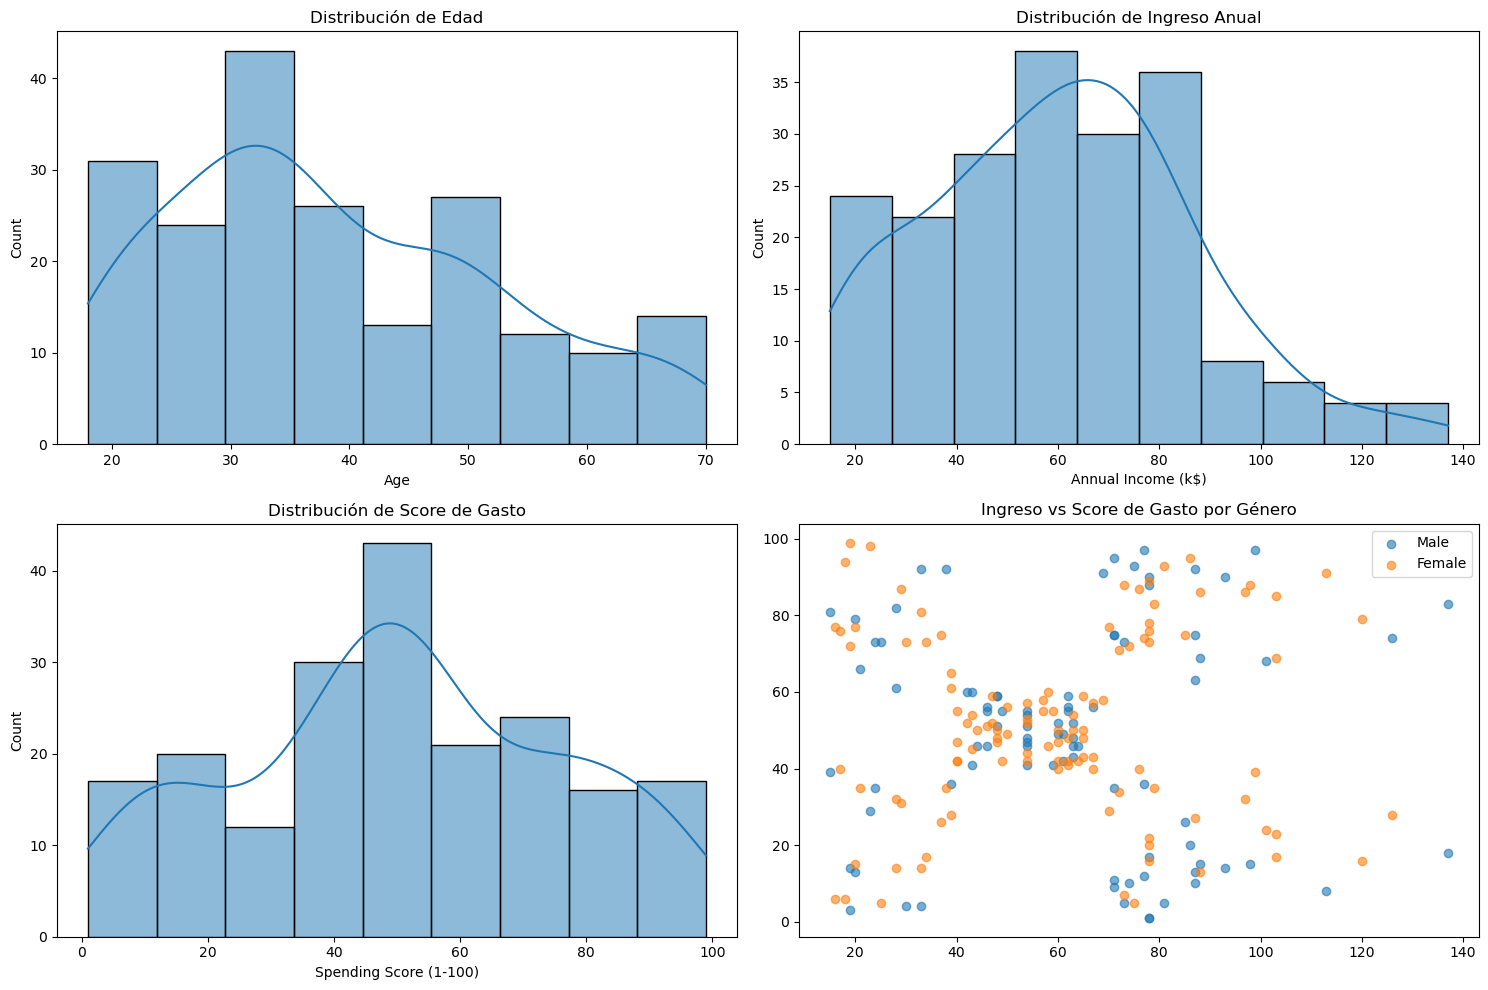

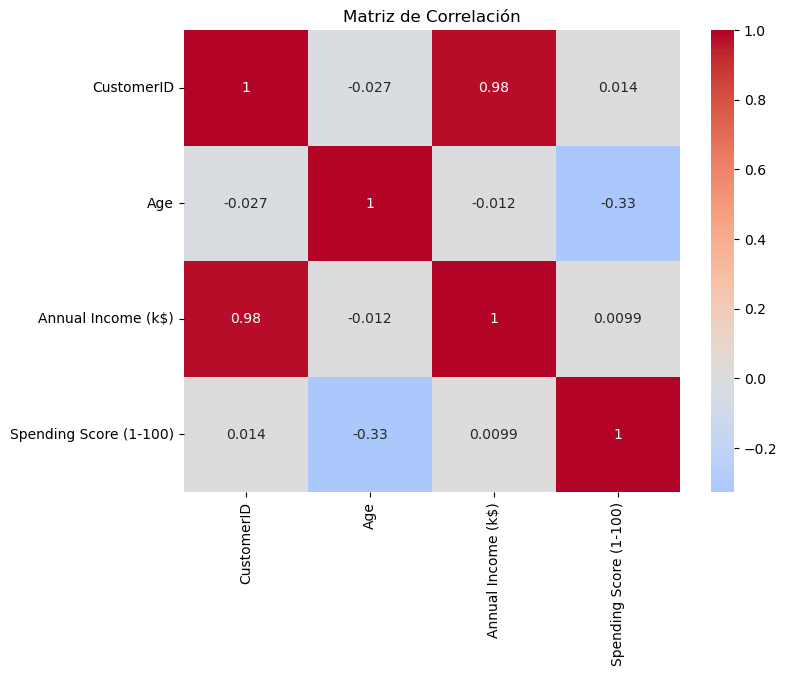


Preparando datos...

Realizando K-means clustering...


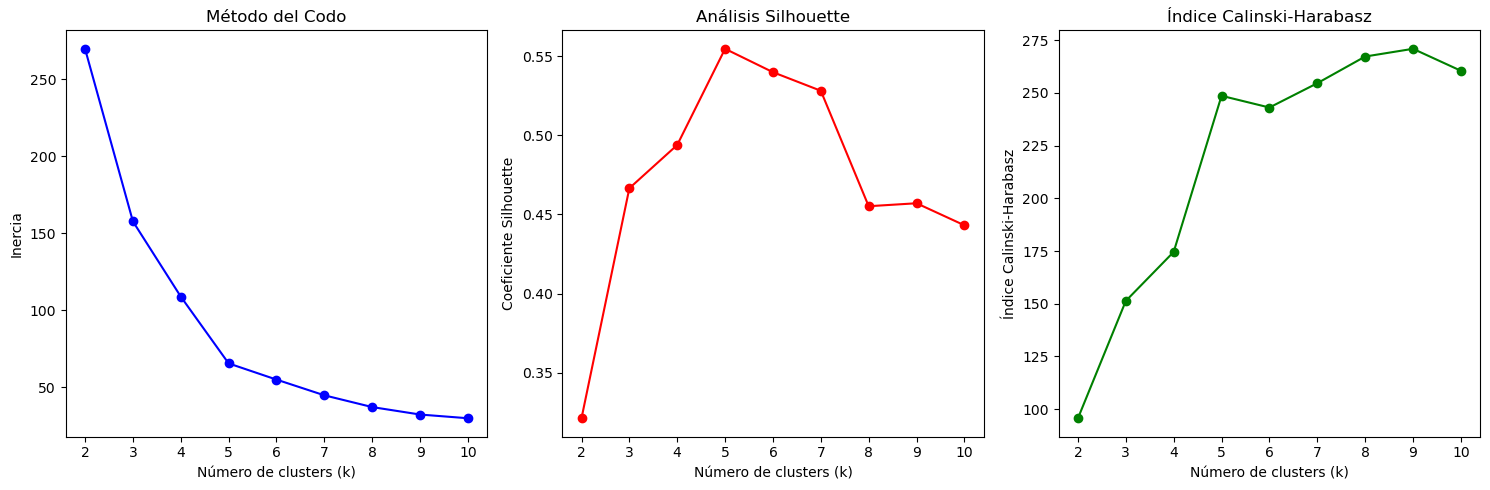


K-means Metrics:
Silhouette Score: 0.555
Calinski-Harabasz Score: 248.649


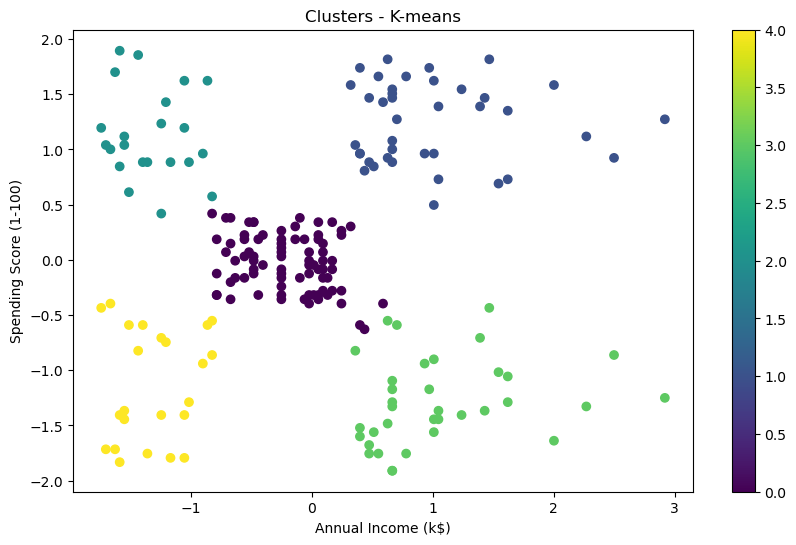


Realizando Hierarchical clustering...


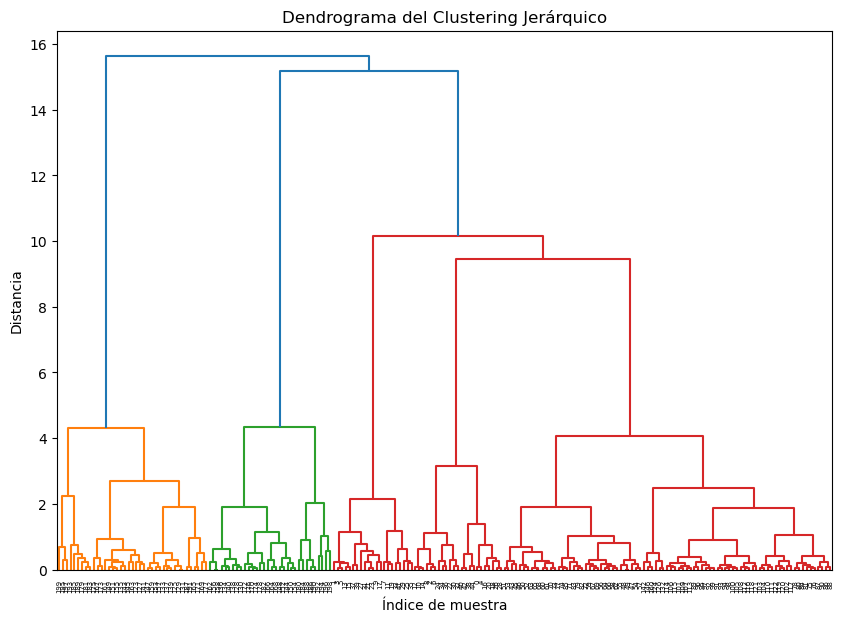


Hierarchical Clustering Metrics:
Silhouette Score: 0.554
Calinski-Harabasz Score: 244.410


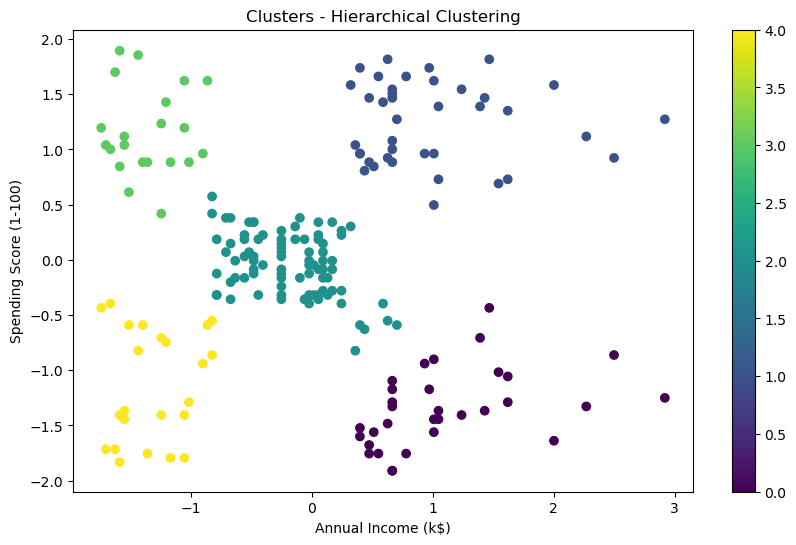

In [11]:


# Configurar el número de hilos para evitar la fuga de memoria en Windows
os.environ['OMP_NUM_THREADS'] = '1'

# Ignorar advertencias específicas
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Análisis Exploratorio de Datos (EDA)
# Aquí se exploran los datos para identificar relaciones, valores atípicos y tendencias.
def perform_eda(df):
    # Configuración básica de estilo
    plt.style.use('default')
    
    # Estadísticas descriptivas
    print("Estadísticas descriptivas:")
    print(df.describe())
    
    # Verificar valores nulos
    print("\nValores nulos:")
    print(df.isnull().sum())
    
    # Crear visualizaciones
    fig = plt.figure(figsize=(15, 10))
    
    # Distribución de variables numéricas con KDE
    ax1 = fig.add_subplot(221)
    sns.histplot(data=df, x='Age', kde=True, ax=ax1)
    ax1.set_title('Distribución de Edad')
    
    ax2 = fig.add_subplot(222)
    sns.histplot(data=df, x='Annual Income (k$)', kde=True, ax=ax2)
    ax2.set_title('Distribución de Ingreso Anual')
    
    ax3 = fig.add_subplot(223)
    sns.histplot(data=df, x='Spending Score (1-100)', kde=True, ax=ax3)
    ax3.set_title('Distribución de Score de Gasto')
    
    ax4 = fig.add_subplot(224)
    for gender in df['Gender'].unique():
        mask = df['Gender'] == gender
        plt.scatter(df[mask]['Annual Income (k$)'], 
                   df[mask]['Spending Score (1-100)'],
                   label=gender, alpha=0.6)
    ax4.set_title('Ingreso vs Score de Gasto por Género')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Matriz de correlación
    plt.figure(figsize=(8, 6))
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación')
    plt.show()

# 2. Preprocesamiento
# Limpieza de datos, manejo de valores faltantes y transformación necesaria.
def preprocess_data(df):
    # Seleccionar características para clustering
    features = ['Annual Income (k$)', 'Spending Score (1-100)']
    X = df[features].copy()
    
    # Estandarizar los datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, features

# 3. Selección y entrenamiento de K-means Clustering
# Entrenamiento del modelo K-means y ajuste de hiperparámetros.
def perform_kmeans(X_scaled, max_clusters=10):
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        calinski_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))
    
    # Visualización de métricas
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Método del codo
    axes[0].plot(range(2, max_clusters + 1), inertias, 'bo-')
    axes[0].set_xlabel('Número de clusters (k)')
    axes[0].set_ylabel('Inercia')
    axes[0].set_title('Método del Codo')
    
    # Coeficiente Silhouette
    axes[1].plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
    axes[1].set_xlabel('Número de clusters (k)')
    axes[1].set_ylabel('Coeficiente Silhouette')
    axes[1].set_title('Análisis Silhouette')
    
    # Índice Calinski-Harabasz
    axes[2].plot(range(2, max_clusters + 1), calinski_scores, 'go-')
    axes[2].set_xlabel('Número de clusters (k)')
    axes[2].set_ylabel('Índice Calinski-Harabasz')
    axes[2].set_title('Índice Calinski-Harabasz')
    
    plt.tight_layout()
    plt.show()
    
    # Entrenar modelo final
    optimal_k = 5
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans_final.fit_predict(X_scaled)
    
    return labels, kmeans_final

# 4. Entrenamiento de Clustering Jerárquico
# Entrenamiento y visualización de dendrograma para el clustering jerárquico.
def perform_hierarchical(X_scaled):
    # Crear dendrograma
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(X_scaled, method='ward')
    dendrogram(linkage_matrix)
    plt.title('Dendrograma del Clustering Jerárquico')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.show()
    
    # Entrenar modelo
    n_clusters = 5
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    labels = hierarchical.fit_predict(X_scaled)
    
    return labels, hierarchical

# 5. Visualización de clusters
# Visualización de los clusters resultantes para una mejor interpretación de los datos.
def visualize_clusters(X_scaled, features, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], 
                         c=labels, cmap='viridis')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(f'Clusters - {title}')
    plt.colorbar(scatter)
    plt.show()

# Ejecutar el análisis
try:
    # Cargar datos
    df = pd.read_csv('Mall_Customers.csv')
    
    # 1. Iniciar análisis exploratorio
    print("Iniciando análisis exploratorio...")
    perform_eda(df)
    
    # 2. Preparar datos
    print("\nPreparando datos...")
    X_scaled, features = preprocess_data(df)
    
    # 3. Realizar K-means clustering
    print("\nRealizando K-means clustering...")
    kmeans_labels, kmeans_model = perform_kmeans(X_scaled)
    print("\nK-means Metrics:")
    print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, kmeans_labels):.3f}")
    visualize_clusters(X_scaled, features, kmeans_labels, "K-means")
    
    # 4. Realizar clustering jerárquico
    print("\nRealizando Hierarchical clustering...")
    hierarchical_labels, hierarchical_model = perform_hierarchical(X_scaled)
    print("\nHierarchical Clustering Metrics:")
    print(f"Silhouette Score: {silhouette_score(X_scaled, hierarchical_labels):.3f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, hierarchical_labels):.3f}")
    visualize_clusters(X_scaled, features, hierarchical_labels, "Hierarchical Clustering")
    
except Exception as e:
    print(f"Error durante la ejecución: {str(e)}")
